### Imports and environment setup
uv venv --python 3.12

.venv\Scripts\activate

uv pip install jupyter yfinance pandas matplotlib torch scikit-learn

Select venv as the kernel

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Download Stock Data

In [2]:
df = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
df = df[['Close']]
df.dropna(inplace=True)
df.head()

C:\Users\Sanya Nanda\AppData\Local\Temp\ipykernel_68076\2153514313.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2020-01-02,72.620842
2020-01-03,71.914833
2020-01-06,72.487854
2020-01-07,72.146942
2020-01-08,73.307518


### Feature Engineering

In [3]:
# generate lag features (previous closing prices)

df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df['lag_3'] = df['Close'].shift(3)
df.dropna(inplace=True)

In [5]:
df.head()

Price,Close,lag_1,lag_2,lag_3
Ticker,AAPL,,,
Date,,,,
2020-01-07,72.146942,72.487854,71.914833,72.620842
2020-01-08,73.307518,72.146942,72.487854,71.914833
2020-01-09,74.864624,73.307518,72.146942,72.487854
2020-01-10,75.033897,74.864624,73.307518,72.146942
2020-01-13,76.636932,75.033897,74.864624,73.307518


In [6]:
# create input and output columns
X = df[['lag_1', 'lag_2', 'lag_3']].values
y = df['Close'].values

In [8]:
X, y

(array([[ 72.487854  ,  71.91483307,  72.62084198],
        [ 72.14694214,  72.487854  ,  71.91483307],
        [ 73.30751801,  72.14694214,  72.487854  ],
        ...,
        [191.64656067, 192.19256592, 193.26467896],
        [191.74581909, 191.64656067, 192.19256592],
        [192.17268372, 191.74581909, 191.64656067]], shape=(1003, 3)),
 array([[ 72.14694214],
        [ 73.30751801],
        [ 74.86462402],
        ...,
        [191.74581909],
        [192.17268372],
        [191.13032532]], shape=(1003, 1)))

In [9]:
# Normalise

from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [10]:
X_scaled, y_scaled

(array([[-1.97983059, -1.99206317, -1.96604779],
        [-1.99006185, -1.97487777, -1.98720785],
        [-1.95523129, -1.98510202, -1.97003363],
        ...,
        [ 1.5962943 ,  1.61517123,  1.64981306],
        [ 1.59927319,  1.59879606,  1.61768036],
        [ 1.61208401,  1.6017729 ,  1.60131584]], shape=(1003, 3)),
 array([[-1.99503794],
        [-1.96018247],
        [-1.91341804],
        ...,
        [ 1.59686469],
        [ 1.60968468],
        [ 1.57837962]], shape=(1003, 1)))

### Prepare dataset for pytorch

In [ ]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
# Train Test Split
split = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### Define Linear Regression model

In [13]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)

    def forward(self, x):
        return self.linear(x)

### Model Training

In [ ]:
model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    model.train()
    for features, target in train_loader:
        output = model(features)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.0357
Epoch 10, Loss: 0.0097
Epoch 20, Loss: 0.0173
Epoch 30, Loss: 0.0102
Epoch 40, Loss: 0.0064
Epoch 50, Loss: 0.0023
Epoch 60, Loss: 0.0297
Epoch 70, Loss: 0.0230
Epoch 80, Loss: 0.0178
Epoch 90, Loss: 0.0016


### Model Evaluation

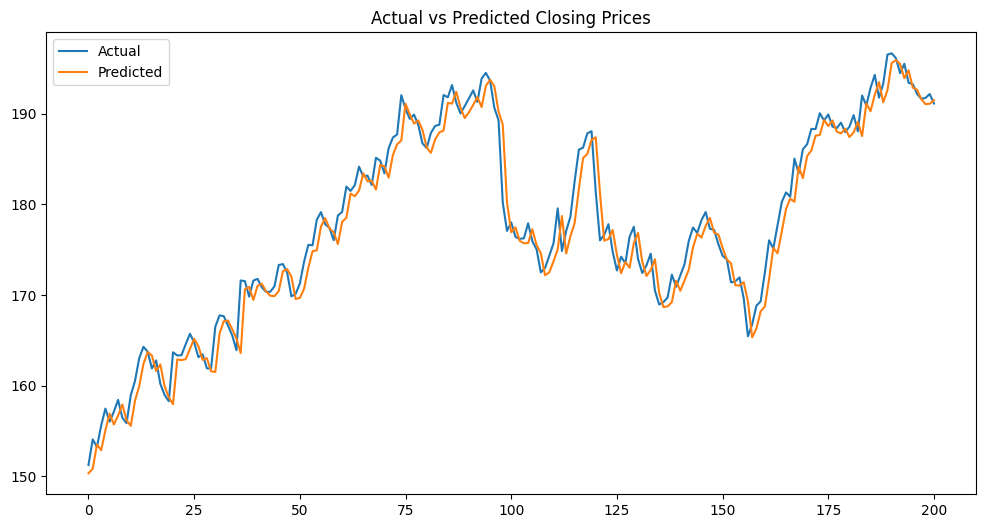

In [ ]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred_scaled = model(X_test_tensor).numpy()

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Closing Prices")
plt.show()

In [21]:
# Predict future value
last_3 = df[['Close']].iloc[-3:].values.flatten()
last_3_scaled = scaler_x.transform([last_3])
with torch.no_grad():
    pred = model(torch.tensor(last_3_scaled, dtype=torch.float32))
    future_price = scaler_y.inverse_transform(pred.numpy())
    print(f"Predicted next day closing price: {future_price[0][0]} for {last_3}")


Predicted next day closing price: 191.1085205078125 for [191.74581909 192.17268372 191.13032532]


In [23]:
# save the model
torch.save(model.state_dict(), "models/p1_linear_model.pth")

import joblib
joblib.dump(scaler_x, "models/p1_scaler_x.pkl")
joblib.dump(scaler_y, "models/p1_scaler_y.pkl")


['models/p1_scaler_y.pkl']